# Malaria Diagnosis CNN (Binary Classification)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow.keras.models import Model

from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Input, Layer

### Data Preparation

In [2]:
dataset, dataset_info = tfds.load(
    "malaria",
    with_info=True,
    shuffle_files=True,
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]']
    )

2025-01-05 21:33:15.053897: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-01-05 21:33:15.053920: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-05 21:33:15.053925: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-05 21:33:15.053937: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-05 21:33:15.053947: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
# Our own custom split function
def split_data(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    
    train_ds = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
    val_ds = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE)).take(int(VAL_RATIO * DATASET_SIZE))
    test_ds = dataset.skip(int((TRAIN_RATIO + VAL_RATIO) * DATASET_SIZE)).take(int(TEST_RATIO * DATASET_SIZE))
    return train_ds, val_ds, test_ds

In [4]:
# TRAIN_RATIO = 0.8
# VAL_RATIO = 0.1
# TEST_RATIO = 0.1
# TOTAL = 10

# train_ds, val_ds, test_ds = split_data(dataset['train'], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [5]:
dataset

[<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>]

In [6]:
train_dataset = dataset[0]
val_dataset = dataset[1]
test_dataset = dataset[2]

In [7]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

22046
2756
2756


In [8]:
for i in val_dataset.take(1):
    print(i)

{'image': <tf.Tensor: shape=(232, 229, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>}


2025-01-05 21:33:15.170034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Data Visualization

In [9]:
def get_label_str(label):
    if (label == 0):
        return 'Parasitized'
    else:
        return 'Uninfected'

2025-01-05 21:33:15.286726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


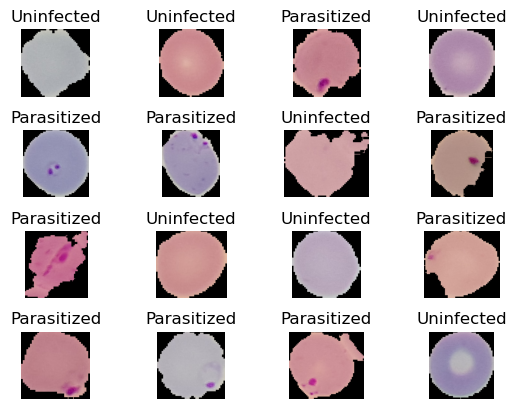

In [10]:
for i, sample in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(sample['image'])
    plt.title(get_label_str(sample['label'].numpy()))
    plt.axis('off')
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

### Data Processing

In [11]:
IMG_SIZE = 224
BATCH_SIZE = 32

In [12]:
def resize_rescale(inputs):
    return tf.image.resize(inputs['image'], (IMG_SIZE, IMG_SIZE))/255, inputs['label']

In [13]:
train_dataset = train_dataset.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [14]:
for image, label in train_dataset.take(1): 
    print(image, label)

tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
 

2025-01-05 21:33:15.581380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Model Creation (Functional API)

In [15]:
func_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = Conv2D(
        filters=6, 
        kernel_size=3, 
        strides=1, 
        padding='valid',
        activation='relu'
    )(func_input)

x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
    
x = Conv2D(
        filters=16, 
        kernel_size=3, 
        strides=1, 
        padding='valid',
        activation='relu'
    )(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)

feature_extractor_model = Model(func_input, output, name='feature_extractor')

feature_extractor_model.summary()

Model: "feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,136 (4.44 KB)

 Trainable params: 1,092 (4.27 KB)

 Non-trainable params: 44 (176.00 B)

In [16]:
func_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = feature_extractor_model(func_input)
    
x = Flatten()(x)
    
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation='sigmoid')(x)

model = Model(func_input, func_output, name='functional_model')

model.summary()

Model: "functional_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_extractor (Functional)  │ (None, 54, 54, 16)     │         1,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

### Model Creation (Sequential API)

In [17]:
model = tf.keras.Sequential([
    InputLayer(shape=(IMG_SIZE, IMG_SIZE, 3)),
    
    Conv2D(
        filters=6, 
        kernel_size=3, 
        strides=1, 
        padding='valid',
        activation='relu'
    ),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    
    Conv2D(
        filters=16, 
        kernel_size=3, 
        strides=1, 
        padding='valid',
        activation='relu'
    ),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    
    Flatten(),
    
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

### Model Subclassing

In [18]:
class FeatureExtractor(Layer):
    def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
        super(FeatureExtractor, self).__init__()
        self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_1 = BatchNormalization()
        self.pool_1 = MaxPool2D(pool_size, strides=2 * strides)
        
        self.conv_2 = Conv2D(filters=filters * 2, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size, strides=2 * strides)

    def call(self, x):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.pool_1(x)
        
        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.pool_2(x)
        
        return x
    
feature_sub_classed = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2)



In [19]:
func_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = feature_sub_classed(func_input)
    
x = Flatten()(x)
    
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation='sigmoid')(x)

model = Model(func_input, func_output, name='functional_model')

model.summary()

Model: "functional_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_extractor               │ (None, 54, 54, 16)     │         1,488 │
│ (FeatureExtractor)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,649 (17.81 MB)

 Trainable params: 4,668,381 (17.81 MB)

 Non-trainable params: 268 (1.05 KB)

In [20]:
class LenetModel(Model):
    def __init__(self):
        super(LenetModel, self).__init__()
        self.feature_extractor = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2)
        
        self.flatten = Flatten()
        
        self.dense_1 = Dense(100, activation='relu')
        self.batch_1 = BatchNormalization()
        
        self.dense_2 = Dense(10, activation='relu')
        self.batch_2 = BatchNormalization()
        
        self.dense_3 = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.batch_1(x)
        x = self.dense_2(x)
        x = self.batch_2(x)
        x = self.dense_3(x)
        
        return x
    
lenet_subclassed_model = LenetModel()
lenet_subclassed_model(tf.zeros([1, 224, 224, 3]))
lenet_subclassed_model.summary()

Model: "lenet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_extractor_1             │ ?                      │         1,488 │
│ (FeatureExtractor)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (1, 46656)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (1, 100)               │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (1, 100)               │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (1, 10)                │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (1, 10)                │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (1, 1)                 │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,649 (17.81 MB)

 Trainable params: 4,668,381 (17.81 MB)

 Non-trainable params: 268 (1.05 KB)

### Custom Layers

In [34]:
class CustomDenseLayer(Layer):
    def __init__(self, output_units, activation):
        super(CustomDenseLayer, self).__init__()
        self.output_units = output_units
        self.activation = activation
    
    def build(self, input_features_shape):
        self.layer_weights = self.add_weight(shape=(input_features_shape[-1], self.output_units), trainable=True, initializer='random_normal')
        self.layer_biases = self.add_weight(shape=(self.output_units,), trainable=True, initializer='random_normal')
        
    def call(self, input_features):
        pre_output = tf.matmul(input_features, self.layer_weights) + self.layer_biases
        
        if (self.activation == 'relu'):
            return tf.nn.relu(pre_output)
        elif (self.activation == 'sigmoid'):
            return tf.math.sigmoid(pre_output)
        else:
            return pre_output

In [35]:
model = tf.keras.Sequential([
    InputLayer(shape=(IMG_SIZE, IMG_SIZE, 3)),
    
    Conv2D(
        filters=6, 
        kernel_size=3, 
        strides=1, 
        padding='valid',
        activation='relu'
    ),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    
    Conv2D(
        filters=16, 
        kernel_size=3, 
        strides=1, 
        padding='valid',
        activation='relu'
    ),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    
    Flatten(),
    
    CustomDenseLayer(100, activation='relu'),
    BatchNormalization(),
    CustomDenseLayer(10, activation='relu'),
    BatchNormalization(),
    CustomDenseLayer(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dense_layer_3            │ (None, 100)            │     4,665,700 │
│ (CustomDenseLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dense_layer_4            │ (None, 10)             │         1,010 │
│ (CustomDenseLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dense_layer_5            │ (None, 1)              │            11 │
│ (CustomDenseLayer)              │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

### Model Training

In [36]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

In [37]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 49s 68ms/step - binary_accuracy: 0.8022 - loss: 0.4157 - val_binary_accuracy: 0.8512 - val_loss: 0.3905
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 46s 67ms/step - binary_accuracy: 0.9298 - loss: 0.2036 - val_binary_accuracy: 0.5203 - val_loss: 0.6575
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 45s 65ms/step - binary_accuracy: 0.9459 - loss: 0.1685 - val_binary_accuracy: 0.5221 - val_loss: 0.8358
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 46s 66ms/step - binary_accuracy: 0.9522 - loss: 0.1584 - val_binary_accuracy: 0.6433 - val_loss: 0.4740
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 45s 66ms/step - binary_accuracy: 0.9546 - loss: 0.1452 - val_binary_accuracy: 0.5218 - val_loss: 0.8070
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 46s 67ms/step - binary_accuracy: 0.9562 - loss: 0.1350 - val_binary_accuracy: 0.9347 - val_loss: 0.2205
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 45s 65ms/step - binary_accuracy: 0.9617 - loss: 0.1201 - val_binary_accuracy: 0.9049 - val_loss:

### Model Evaluation and Testing

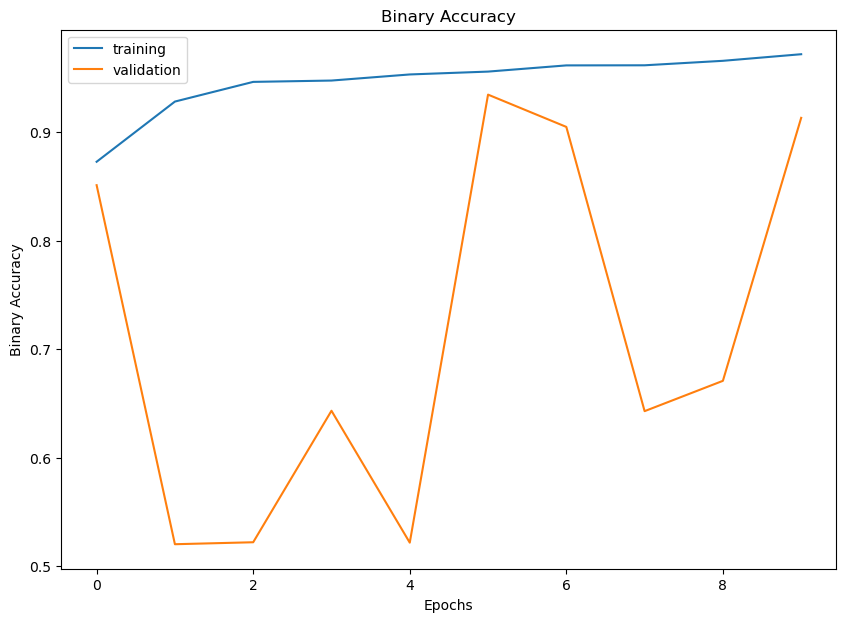

In [40]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

plt.title('Binary Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Binary Accuracy')

plt.legend(['training', 'validation'])

plt.show()

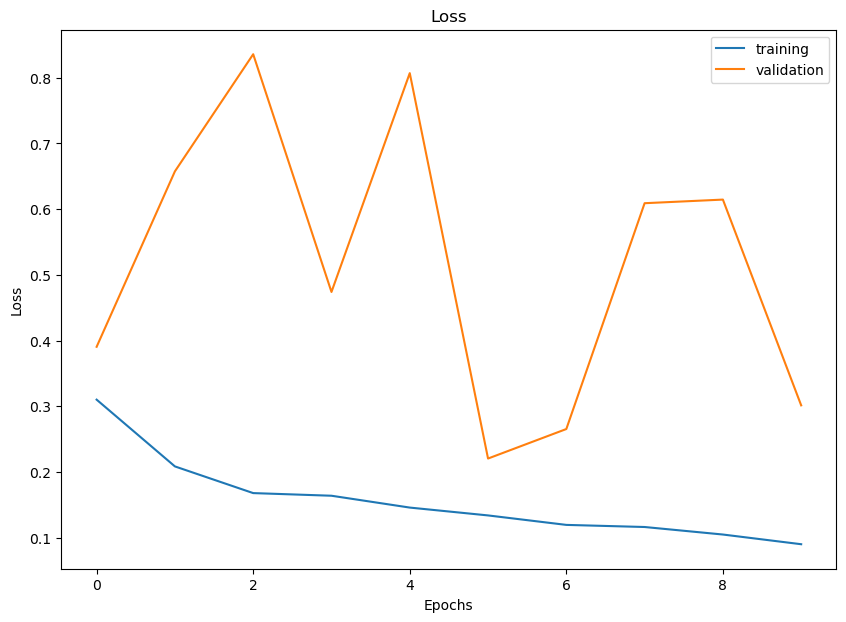

In [39]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(['training', 'validation'])

plt.show()

In [41]:
model.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - binary_accuracy: 0.9221 - loss: 0.2672


[0.28031548857688904, 0.921625554561615]

In [42]:
def parasite_or_not(x):
    if x < 0.5:
        return 'P'
    else:
        return 'U'

In [43]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


'U'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


2025-01-05 22:08:54.509529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


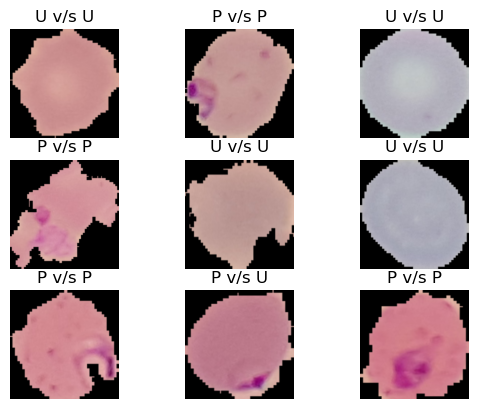

In [44]:
for image, label in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[i])
        plt.title(parasite_or_not(label.numpy()[i]) + " v/s " + parasite_or_not(model.predict(image)[i][0]))
        plt.axis('off')

### Loading & Saving Model

In [73]:
model.save('LenetSavedModel.keras')

loaded_model = tf.keras.models.load_model('LenetSavedModel.keras')

loaded_model.summary()

/opt/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,336,332 (35.62 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

 Optimizer params: 4,668,035 (17.81 MB)